In [391]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error

In [17]:
df = pd.read_csv("players-stats.csv")

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   league               413 non-null    object 
 1   season               413 non-null    int64  
 2   team                 413 non-null    object 
 3   player               413 non-null    object 
 4   nation               413 non-null    object 
 5   pos                  413 non-null    object 
 6   age                  413 non-null    int64  
 7   born                 413 non-null    int64  
 8   mp                   413 non-null    int64  
 9   starts               413 non-null    int64  
 10  min                  413 non-null    int64  
 11  90s                  413 non-null    float64
 12  gls                  413 non-null    int64  
 13  ast                  413 non-null    int64  
 14  g+a                  413 non-null    int64  
 15  g-pk                 413 non-null    int

In [19]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [20]:
df.head()

,league,season,team,player,nation,pos,age,born,mp,starts,...,g+a-pk_per90,xg_per90,xag_per90,xg+xag_per90,npxg_per90,npxg+xag_per90,other_positions,contract_expiration,value_euros,years_remaining
0,ENG-Premier League,2526,West Ham,Jarrod Bowen,ENG,"FW,MF",29,1996,17,17,...,0.35,0.21,0.11,0.31,0.21,0.31,NaN,2030-06-30,3500000.0,4.5
1,ENG-Premier League,2526,Sunderland,Robin Roefs,NED,GK,22,2003,17,17,...,0.00,0.00,0.02,0.02,0.00,0.02,NaN,2030-06-30,1800000.0,4.5
2,ENG-Premier League,2526,Tottenham,Guglielmo Vicario,ITA,GK,29,1996,17,17,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,2028-06-30,3000000.0,2.5
3,ENG-Premier League,2526,Everton,Jordan Pickford,ENG,GK,31,1994,17,17,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,2029-06-30,1500000.0,3.5
4,ENG-Premier League,2526,Brentford,Sepp van den Berg,NED,DF,24,2001,17,17,...,0.00,0.10,0.03,0.13,0.10,0.13,NaN,2029-06-30,2800000.0,3.5


In [21]:
df.isna().sum()

league                   0
season                   0
team                     0
player                   0
nation                   0
pos                      0
age                      0
born                     0
mp                       0
starts                   0
min                      0
90s                      0
gls                      0
ast                      0
g+a                      0
g-pk                     0
pk                       0
pkatt                    0
crdy                     0
crdr                     0
xg                       0
npxg                     0
xag                      0
npxg+xag                 0
prgc                     0
prgp                     0
prgr                     0
gls_per90                0
ast_per90                0
g+a_per90                0
g-pk_per90               0
g+a-pk_per90             0
xg_per90                 0
xag_per90                0
xg+xag_per90             0
npxg_per90               0
npxg+xag_per90           0
o

In [22]:
total_number_of_observation = len(df)
num_of_observation_without_contract_expiration_data = df["contract_expiration"].isna().sum()
num_of_observation_without_position_data = df["other_positions"].isna().sum()
print(f"percentage of contract_expiration missing data: {(num_of_observation_without_contract_expiration_data / total_number_of_observation)*100}%")
print(f"percentage of position missing data: {(num_of_observation_without_position_data / total_number_of_observation)*100}%")

percentage of contract_expiration missing data: 4.358353510895883%
percentage of position missing data: 60.290556900726386%


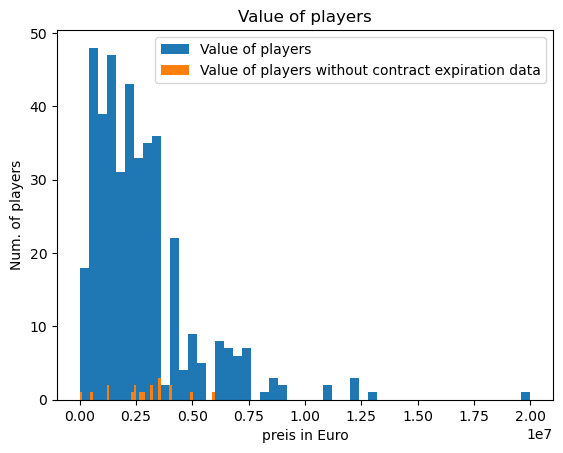

In [23]:
price = df["value_euros"]
price_no_contract = df["value_euros"][df["contract_expiration"].isna()]

plt.hist(price, bins=50, label="Value of players")
plt.hist(price_no_contract, bins=50, label="Value of players without contract expiration data")

plt.xlabel("preis in Euro")
plt.ylabel("Num. of players")
plt.title("Value of players")

plt.legend()
plt.show()

**prices of players that dont have contract expiration data is within a reasonable range for me to just drop these rows. Then I can drop the whole column as its represented by the column "years_remaining". That is valid also for the columns "born, " which are represented by the columns "age, " respectively. Since the percentage of players without position data is very high I will try to train the model without taking this variable into consideration.**

In [24]:
df = df.drop("other_positions", axis=1)
df = df.dropna(subset=['contract_expiration'])
df = df.drop("born", axis=1)
df = df.drop("contract_expiration", axis=1)

In [25]:
df.describe()

,season,age,mp,starts,min,90s,gls,ast,g+a,g-pk,...,g+a_per90,g-pk_per90,g+a-pk_per90,xg_per90,xag_per90,xg+xag_per90,npxg_per90,npxg+xag_per90,value_euros,years_remaining
count,395.0,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,...,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,3.950000e+02,395.000000
mean,2526.0,26.027848,11.359494,8.240506,740.807595,8.229620,0.994937,0.681013,1.675949,0.929114,...,0.204962,0.109165,0.197949,0.125114,0.089848,0.214582,0.118228,0.207696,2.654380e+06,2.783544
std,0.0,4.092426,4.879500,5.797810,488.670156,5.430526,1.772599,1.070850,2.403742,1.651038,...,0.295012,0.204155,0.288994,0.154843,0.118128,0.220927,0.142378,0.212049,2.353758e+06,1.569250
min,2526.0,17.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000e+05,0.500000
25%,2526.0,23.000000,8.000000,3.000000,294.500000,3.300000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.020000,0.010000,0.050000,0.020000,0.050000,1.000000e+06,1.500000
50%,2526.0,26.000000,13.000000,8.000000,700.000000,7.800000,0.000000,0.000000,1.000000,0.000000,...,0.110000,0.000000,0.100000,0.070000,0.050000,0.160000,0.070000,0.160000,2.000000e+06,2.500000
75%,2526.0,28.000000,16.000000,14.000000,1190.500000,13.250000,1.000000,1.000000,3.000000,1.000000,...,0.310000,0.160000,0.300000,0.170000,0.130000,0.310000,0.170000,0.310000,3.500000e+06,4.500000
max,2526.0,39.000000,17.000000,17.000000,1530.000000,17.000000,19.000000,7.000000,23.000000,18.000000,...,1.960000,1.960000,1.960000,1.030000,0.910000,1.500000,0.930000,1.500000,2.000000e+07,8.500000


**Since the value is showing a long tail, it's recommended to apply a logarithmic distribution to get rid of it**

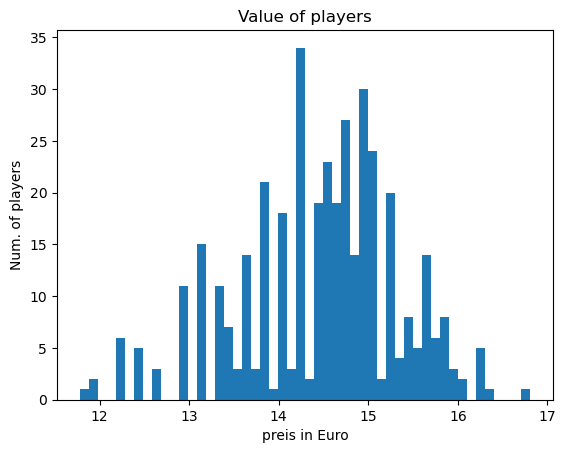

In [37]:
df["value_euros"] = np.log1p(df["value_euros"])
plt.hist(df["value_euros"], bins=50)

plt.xlabel("preis in Euro")
plt.ylabel("Num. of players")
plt.title("Value of players")

plt.show()

In [34]:
columns = df.columns
categorical = []
numerical = []
for c in columns:
  if c != "value_euros" and c != "league" and c != "season" and c != "player":
    if df[c].dtype == "object":
      categorical.append(c)
    if df[c].dtype == "int64" or df[c].dtype == "float64":
      numerical.append(c)
print(categorical)
print(numerical)

['team', 'nation', 'pos']
['age', 'mp', 'starts', 'min', '90s', 'gls', 'ast', 'g+a', 'g-pk', 'pk', 'pkatt', 'crdy', 'crdr', 'xg', 'npxg', 'xag', 'npxg+xag', 'prgc', 'prgp', 'prgr', 'gls_per90', 'ast_per90', 'g+a_per90', 'g-pk_per90', 'g+a-pk_per90', 'xg_per90', 'xag_per90', 'xg+xag_per90', 'npxg_per90', 'npxg+xag_per90', 'years_remaining']


**looking at how each variable affect the player value**

age


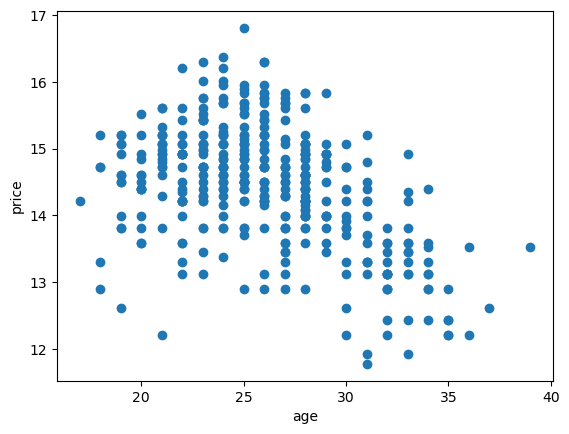

mp


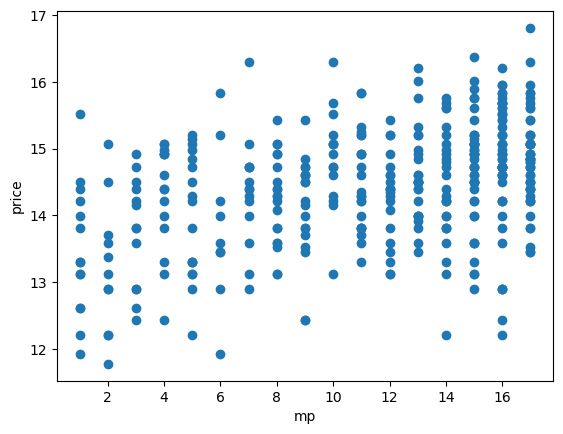

starts


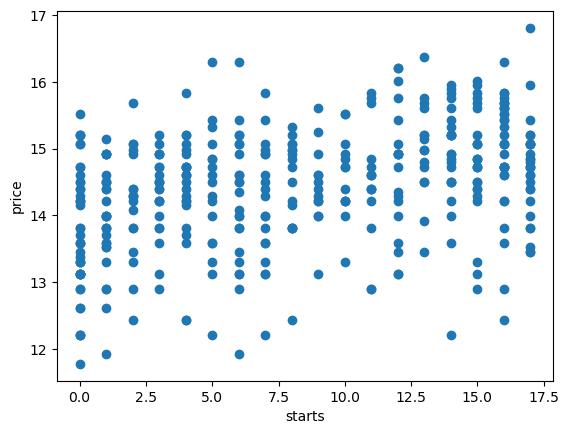

min


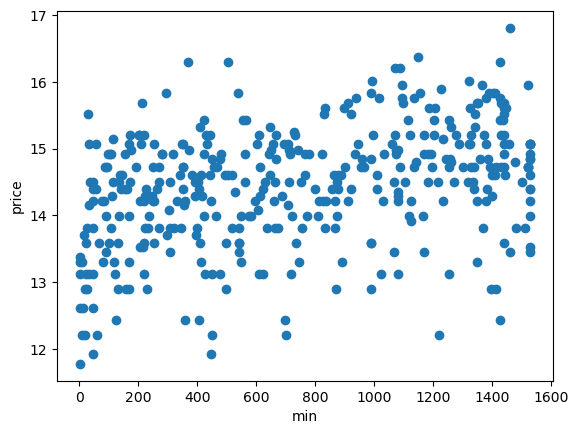

90s


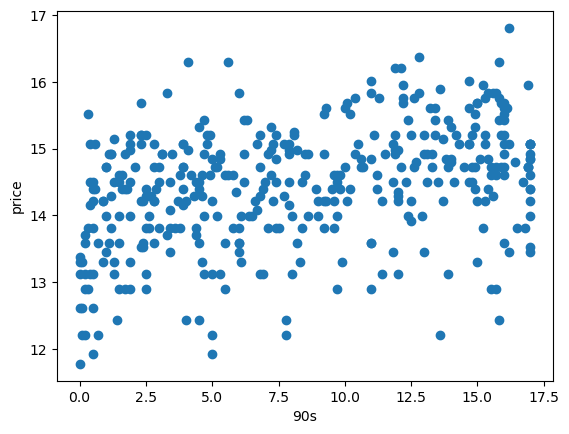

gls


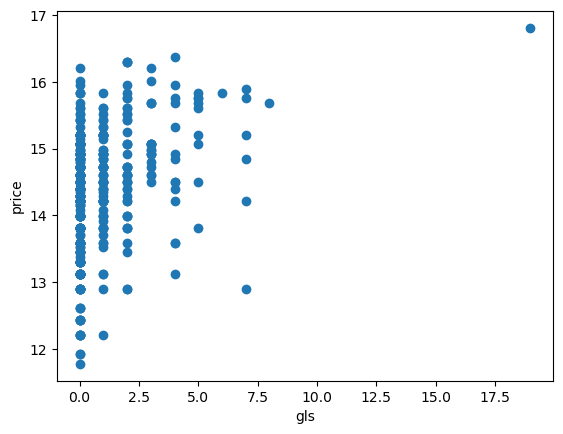

ast


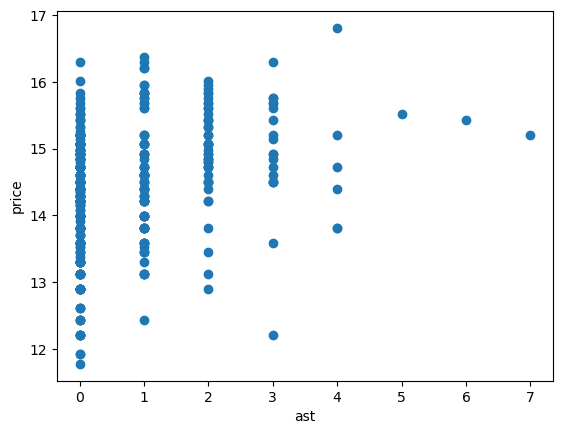

g+a


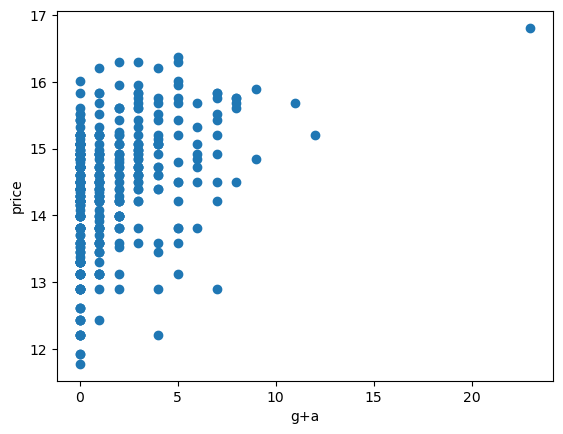

g-pk


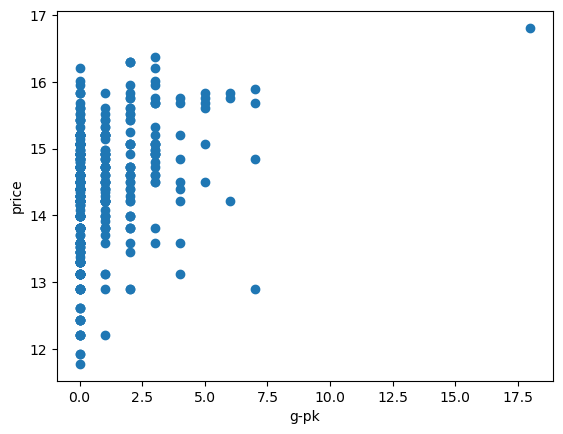

pk


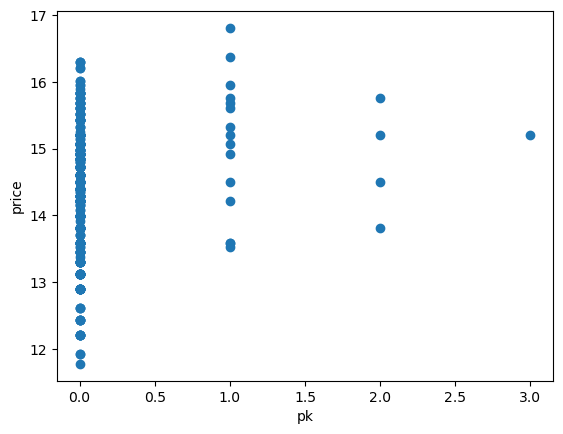

pkatt


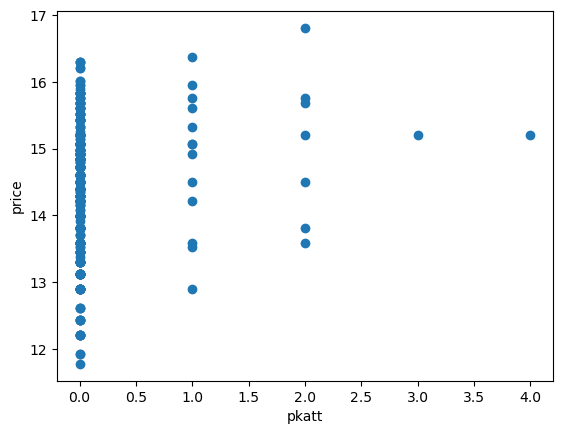

crdy


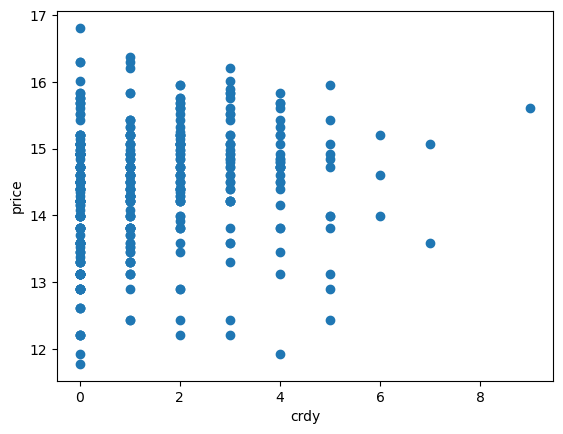

crdr


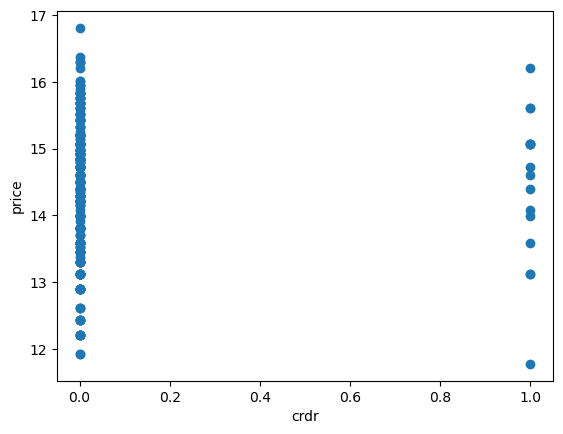

xg


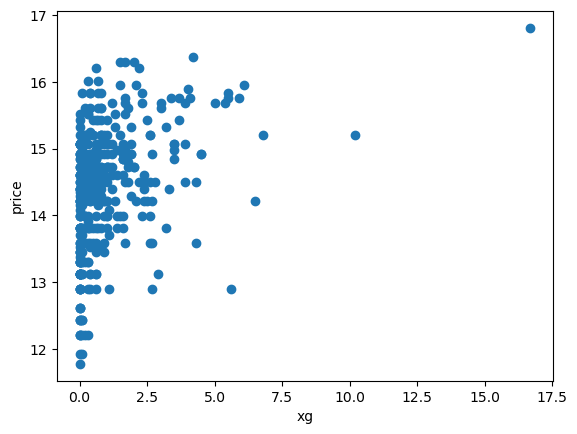

npxg


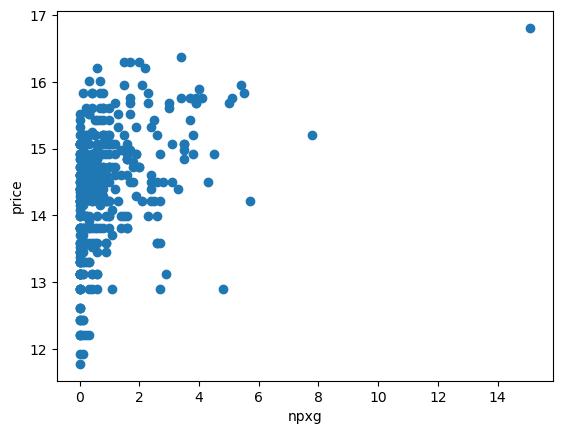

xag


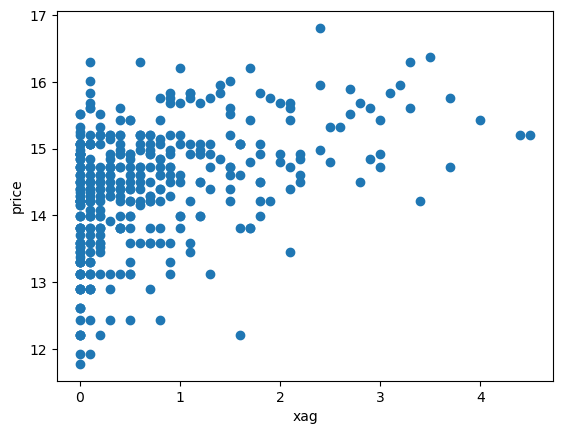

npxg+xag


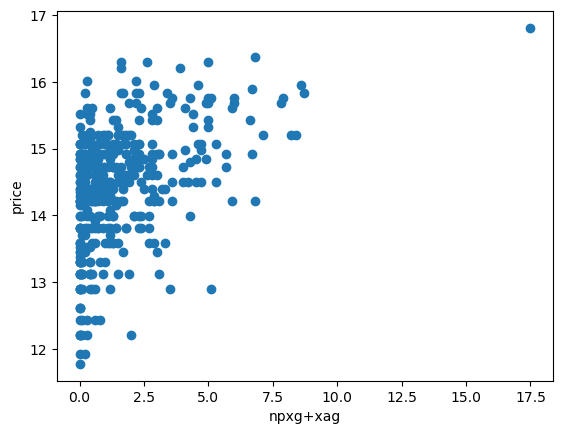

prgc


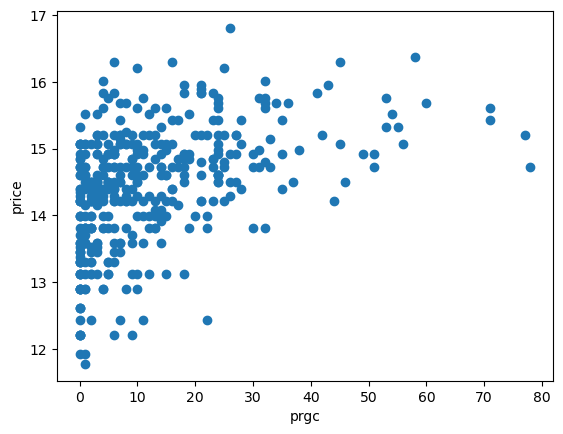

prgp


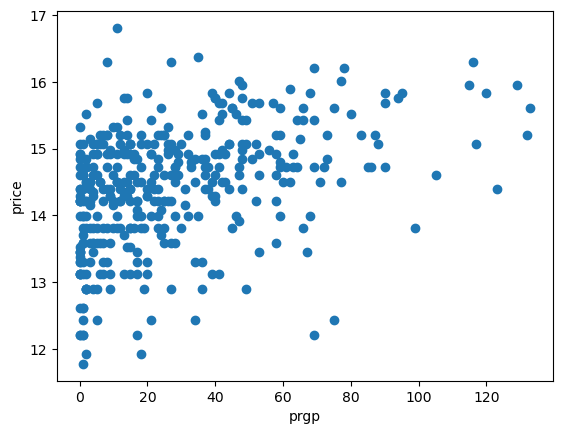

prgr


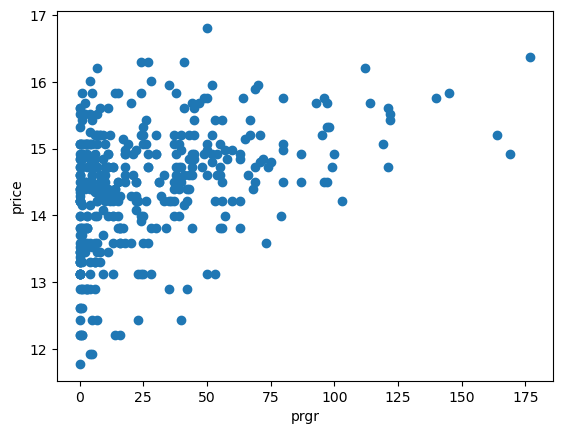

gls_per90


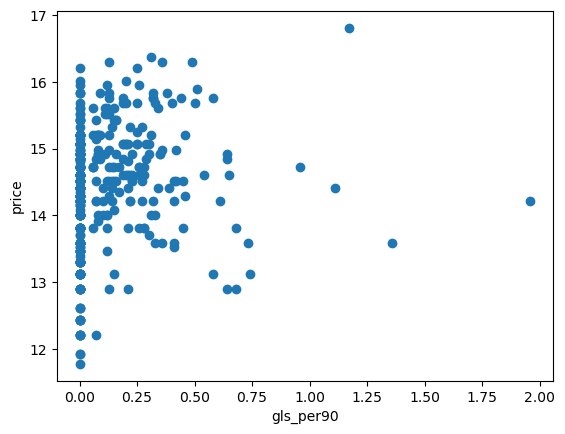

ast_per90


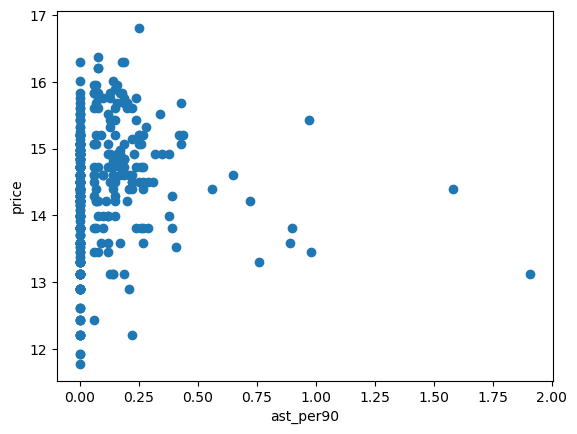

g+a_per90


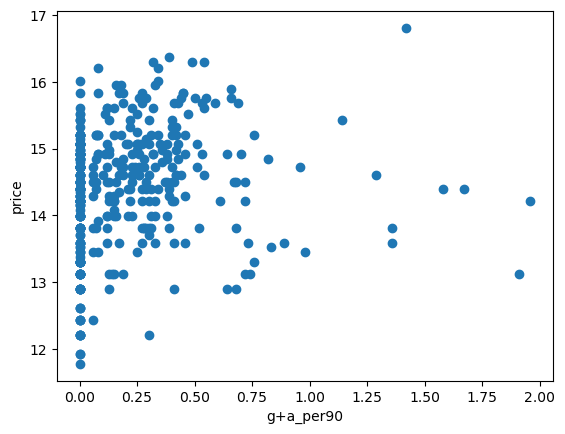

g-pk_per90


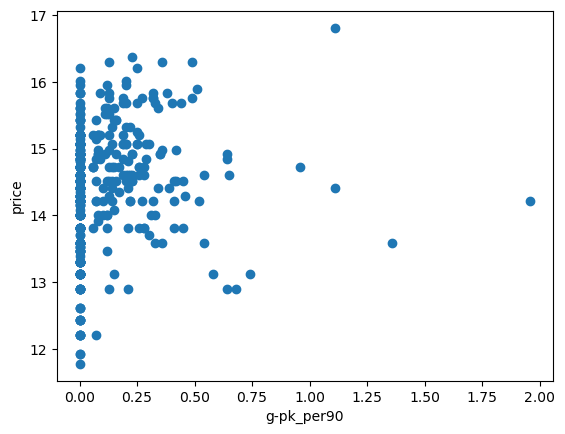

g+a-pk_per90


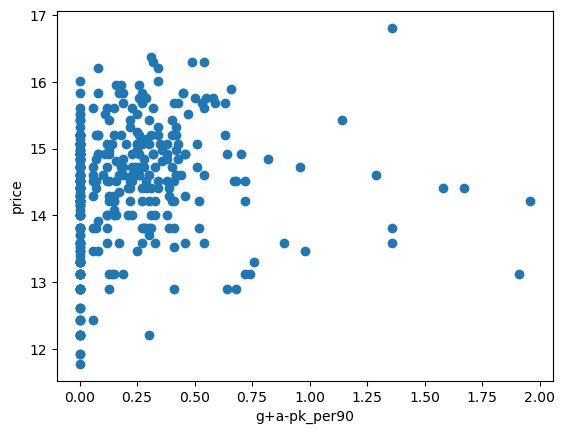

xg_per90


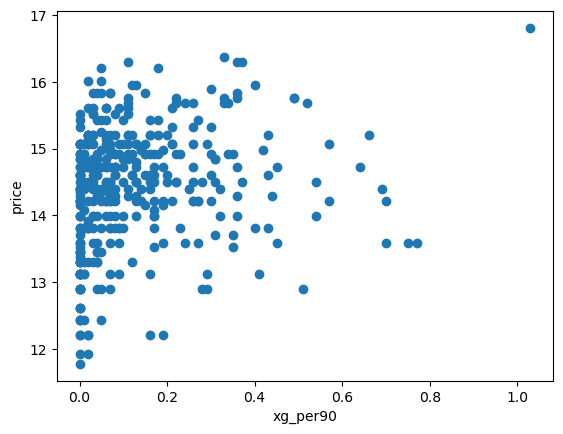

xag_per90


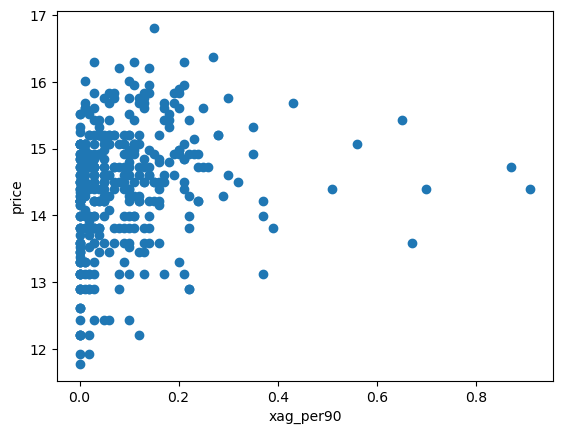

xg+xag_per90


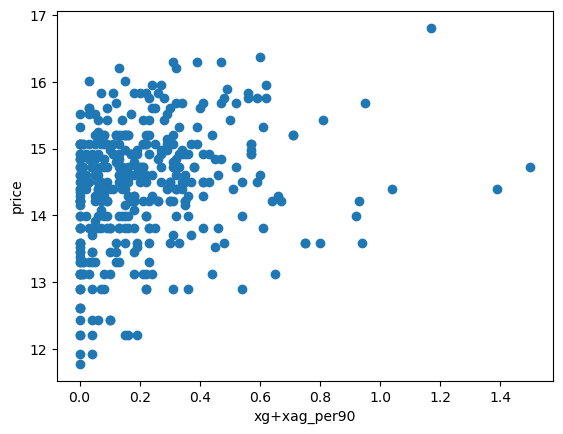

npxg_per90


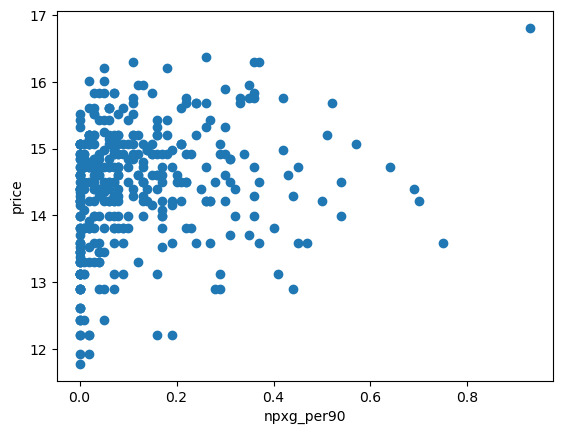

npxg+xag_per90


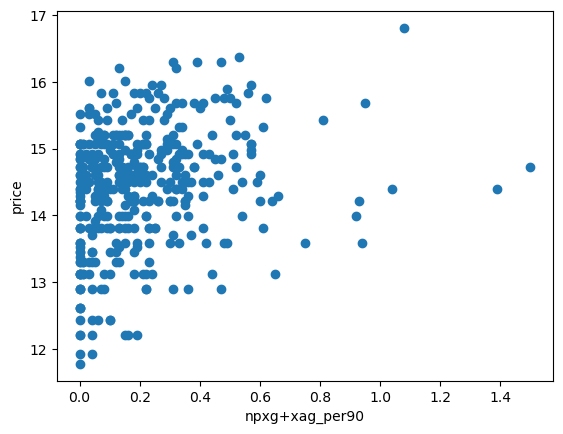

years_remaining


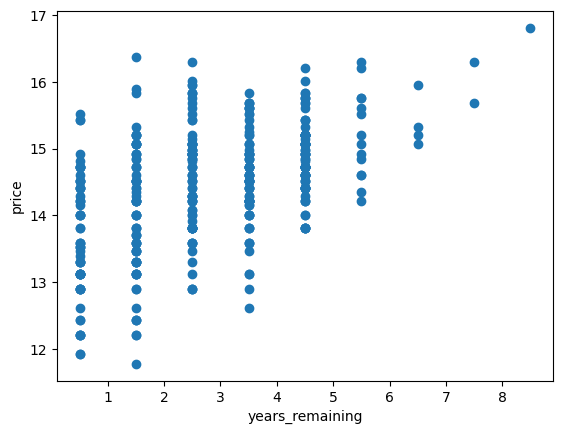

In [41]:
for n in numerical:
    print(n)
    plt.scatter(df[n], df["value_euros"])
    plt.xlabel(n)
    plt.ylabel("price")
    
    plt.show()

**Multiple columns technically provide the same information, for example "g + a" is the combination of "gls" and "ast", also "gls" can replace "g-pk", "pk" and "pkatt". The same goes for the columns "xg, npxg, xag, npxg+xag", as all of them are expected basic performance stats. We can train the model only with "npxg+xag". Also each of these metrics, is calculated as a proportion per 90 mins, which might be interesting. However, feeding this to the model might be missleading. It would be better, if the model can identify patterns between "min" and "g + a" itself. This also tells us that "min" can replace "mp", "starts", "90s".**

**Feature importance:**

In [300]:
df["value_euros"].describe().round(2)

count    395.00
mean      14.44
std        0.90
min       11.78
25%       13.82
50%       14.51
75%       15.07
max       16.81
Name: value_euros, dtype: float64

In [255]:
numerical = ['age', 'mp', 'g+a', 'g-pk', 'crdy', 'crdr', 'npxg+xag', 'prgc', 'prgp', 'prgr', 'years_remaining']
for n in numerical:
  print(n)
  print(np.corrcoef(df[n], df["value_euros"]).round(2))

age
[[ 1.   -0.46]
 [-0.46  1.  ]]
mp
[[1.   0.42]
 [0.42 1.  ]]
g+a
[[1.   0.38]
 [0.38 1.  ]]
g-pk
[[1.   0.33]
 [0.33 1.  ]]
crdy
[[1.   0.16]
 [0.16 1.  ]]
crdr
[[1. 0.]
 [0. 1.]]
npxg+xag
[[1.   0.44]
 [0.44 1.  ]]
prgc
[[1.   0.45]
 [0.45 1.  ]]
prgp
[[1.  0.4]
 [0.4 1. ]]
prgr
[[1.   0.38]
 [0.38 1.  ]]
years_remaining
[[1.   0.51]
 [0.51 1.  ]]


In [96]:
X = df[['team', 'nation', 'pos']].copy()
for col in X.columns:
    X[col] = LabelEncoder().fit_transform(X[col])
y = df["value_euros"].values

In [97]:
mi = mutual_info_regression(X, df["value_euros"], discrete_features=True)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

team      0.215234
pos       0.072468
nation    0.036018
dtype: float64


                      mean       std        min        max     median
team                                                                 
Arsenal          15.374155  0.613109  13.710151  16.380460  15.424949
Aston Villa      14.363592  0.925971  12.429220  15.761421  14.667885
Bournemouth      14.282367  0.650592  13.122365  15.687313  14.403298
Brentford        14.299927  0.771439  12.206078  15.068274  14.455978
Brighton         14.383149  0.865330  12.429220  15.607270  14.667885
Burnley          13.522294  0.789214  12.206078  14.731802  13.560099
Chelsea          15.091801  0.610406  13.997833  16.300417  15.068274
Crystal Palace   14.325256  0.812986  12.899222  15.607270  14.397087
Everton          14.305065  0.722922  12.611541  15.319588  14.508658
Fulham           14.027220  0.743923  12.611541  14.914123  13.954327
Leeds United     13.997556  0.549663  12.206078  14.508658  14.220976
Liverpool        14.946245  0.911459  13.122365  16.300417  14.914123
Manchester City  15.

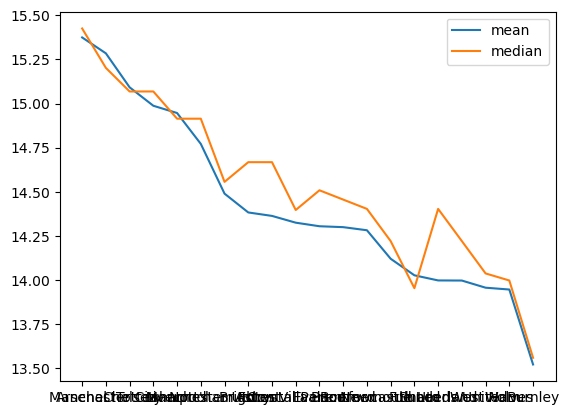

             mean       std        min        max     median
nation                                                      
ALB     13.815512       NaN  13.815512  13.815512  13.815512
ALG     15.201805       NaN  15.201805  15.201805  15.201805
ARG     14.711506  0.873641  13.304687  15.955577  14.503633
AUT     14.603968       NaN  14.603968  14.603968  14.603968
BEL     14.368887  0.771598  13.122365  15.250595  14.603968
BFA     14.095320  1.375965  13.122365  15.068274  14.095320
BRA     14.899753  0.617271  13.592368  15.830414  14.879627
BUL     13.710151       NaN  13.710151  13.710151  13.710151
CIV     14.759046  0.453902  14.403298  15.424949  14.603968
CMR     15.145172  0.999869  13.997833  15.830414  15.607270
COD     13.921663  1.294073  12.429220  14.731802  14.603968
COL     14.109405  0.533932  13.592368  14.808763  14.018244
CRO     12.899222       NaN  12.899222  12.899222  12.899222
CZE     13.997833       NaN  13.997833  13.997833  13.997833
DEN     14.228147  0.585

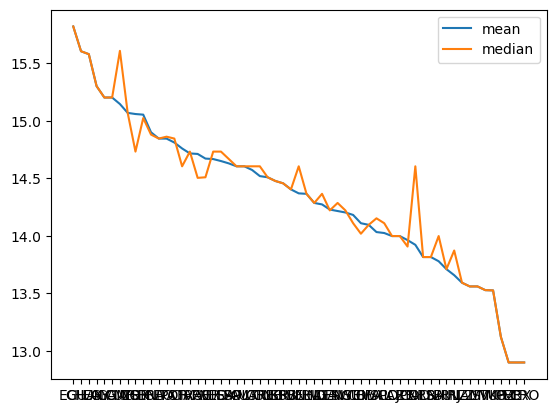

            mean       std        min        max     median
pos                                                        
DF     14.314046  0.907285  11.918397  16.012735  14.508658
DF,FW  13.914009  0.998028  12.611541  15.150512  14.109405
DF,MF  14.105907  0.966412  12.206078  15.424949  14.077876
FW     14.565015  0.892727  12.206078  16.811243  14.603968
FW,DF  14.213485  0.394282  13.815512  14.603968  14.220976
FW,MF  14.505843  0.690346  13.122365  15.761421  14.508658
GK     14.083221  0.803487  12.206078  15.319588  14.220976
MF     14.669007  0.899326  12.206078  16.300417  14.731802
MF,DF  14.018740  1.607509  11.775297  15.955577  14.508658
MF,FW  14.662416  0.752794  13.122365  16.213406  14.620230


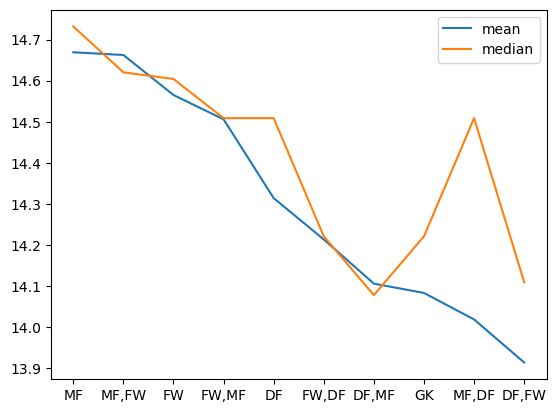

In [193]:
for c in categorical:
    data = df.groupby(c).value_euros.agg(["mean", "std", "min", "max", "median"])
    print(data)
    data = data.sort_values("mean", ascending=False)
    plt.plot(data.index, data["mean"], label="mean")
    plt.plot(data.index, data["median"], label="median")
    plt.legend()
    plt.show()

In [449]:
mi = mutual_info_regression(df[numerical], df["value_euros"])

In [450]:
mi_series = pd.Series(mi, index=numerical).sort_values(ascending=False)
print(mi_series)

age               0.24
years_remaining   0.21
prgc              0.12
prgr              0.10
npxg+xag          0.08
prgp              0.08
mp                0.08
g-pk              0.07
g+a               0.07
crdr              0.01
crdy              0.00
dtype: float64


**After doing the feature importance analysis I can see that the follwing features are the most important and have significance on my model: age, years_remaining, prgc, team, pos, and npxg+xag.**

In [311]:
numerical_final = ["age", "years_remaining", "prgc", "npxg+xag"] #['age', 'npxg+xag', 'starts'] #['age', 'mp', 'npxg+xag', 'prgc', 'prgp', 'prgr', 'years_remaining'] 
categorical_final = ["team", "pos"]
target = ["value_euros"]
df_final = df[numerical_final + categorical_final + target]


**Model Training**

In [312]:
df_final.head()

,age,years_remaining,prgc,npxg+xag,team,pos,value_euros
0,29,4.5,56,5.3,West Ham,"FW,MF",15.068274
1,22,4.5,0,0.4,Sunderland,GK,14.403298
2,29,2.5,0,0.0,Tottenham,GK,14.914123
3,31,3.5,0,0.0,Everton,GK,14.220976
4,24,3.5,13,2.1,Brentford,DF,14.845130


In [313]:
df_full_train, test = train_test_split(df_final, test_size=0.2, random_state=1)
train, val = train_test_split(df_full_train, test_size= 0.25, random_state=1)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

y_train = train["value_euros"].values
y_val = val["value_euros"].values
y_test = test["value_euros"].values

del(train["value_euros"])
del(val["value_euros"])
del(test["value_euros"])

In [314]:
dv = DictVectorizer(sparse=False)

In [315]:
train_dict = train.to_dict(orient="records")
val_dict = val.to_dict(orient="records")

x_train = dv.fit_transform(train_dict)
x_val = dv.transform(val_dict)

In [322]:
def evaluating(y_pred, y_val, y_train_pred, y_train):
    return {"R2" : r2_score(y_pred, y_val),
            "MAE" : mean_absolute_error(y_pred, y_val),
            "RMSE" : root_mean_squared_error(y_pred, y_val),
            "R2_train" : r2_score(y_train_pred, y_train),
            "MAE_train" : mean_absolute_error(y_train_pred, y_train),
            "RMSE_train" : root_mean_squared_error(y_train_pred, y_train)}

models = {"Linear_Regression" : LinearRegression(),
            "Decision_Tree" : DecisionTreeRegressor(),
            "Random_Forest" : RandomForestRegressor(random_state=1)}  

In [323]:
results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred = model.predict(x_val)
    metrics = evaluating(y_pred, y_val, y_pred_train, y_train)
    metrics["model"] = name
    results.append(metrics)

In [324]:
result_df = pd.DataFrame(results).set_index("model").sort_values("R2", ascending=False)
result_df

,R2,MAE,RMSE,R2_train,MAE_train,RMSE_train
model,,,,,,
Linear_Regression,0.482576,0.443464,0.555674,0.494730,3.986092e-01,5.129491e-01
Random_Forest,0.351021,0.386071,0.529221,0.924145,1.692866e-01,2.138350e-01
Decision_Tree,0.170501,0.610254,0.858686,1.000000,4.497106e-17,2.826387e-16


**Even after tuning the parameters of the models Random_Forest and Decision_tree (max_depth) it was clear that both models were overfitting the training data and fails to predict on the evaluation data more perceisly than Linear_Regression**

In [370]:
xgb_model = XGBRegressor(n_estimators=3000, 
                         learning_rate=0.02, 
                         early_stopping_rounds=200,  
                         subsample=0.8, 
                         colsample_bytree=0.7,
                         objective="reg:squarederror",
                         random_state=42,
                         n_jobs=-1)
xgb_model.fit(x_train, y_train,
              eval_set=[(x_val, y_val)],
              verbose=False)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",200
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [371]:
y_pred_xgb = xgb_model.predict(x_val)

In [372]:
R2_xgb = r2_score(y_pred_xgb, y_val)
MAE_xgb = mean_absolute_error(y_pred_xgb, y_val)
RMSE =  root_mean_squared_error(y_pred_xgb, y_val)

In [373]:
print(R2_xgb, MAE_xgb, RMSE)

0.5409669293213399 0.3332816609549476 0.46656093652040587


**Given the evaluation metrics results above, XGBoost model achieved best results.**

**Parameters Fine Tuning**

In [376]:
param_grid = {
    'n_estimators': [100, 500, 1000, 3000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
}

xgb_tuner = XGBRegressor(random_state=42, n_jobs=-1, early_stopping_rounds=200, subsample=0.8, colsample_bytree=0.7,)

grid_search = GridSearchCV(
    estimator=xgb_tuner,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=1
)

grid_search.fit(x_train, y_train,
                eval_set=[(x_train, y_train)],
                verbose=False)

best_model = grid_search.best_estimator_
print(f"Best Params Are: {grid_search.best_params_}")

#Validation of tuned model
y_pred_tuned = best_model.predict(x_val)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params Are: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 3000}


In [379]:
R2_xgb_tuned = r2_score(y_pred_tuned, y_val)
MAE_xgb_tuned = mean_absolute_error(y_pred_tuned, y_val)
RMSE_tuned = root_mean_squared_error(y_pred_tuned, y_val)

In [385]:
print(R2_xgb_tuned, MAE_xgb_tuned,RMSE_tuned)

0.5778318128094178 0.34659244629189834 0.4874109526339664


**Trying the final model on the testing data set**

In [417]:
dict_test = test.to_dict(orient="records")
x_test = dv.transform(dict_test)

In [418]:
y_pred_final = best_model.predict(x_test)

R2_final = r2_score(y_pred_final, y_test)
MAE_final = mean_absolute_error(y_pred_final, y_test)
RMSE_final = root_mean_squared_error(y_pred_final, y_test)

In [419]:
print(R2_final, MAE_final, RMSE_final)

0.6724562964785655 0.38651742806519573 0.4991265749167752


**Training the model on the full train dataset**

In [420]:
y_full = df_full_train.value_euros.values
df_full_train = df_full_train.drop("value_euros", axis=1)

AttributeError: 'DataFrame' object has no attribute 'value_euros'

In [421]:
dict_full = df_full_train.to_dict(orient="records")
x_full = dv.transform(dict_full)

final_model = XGBRegressor(n_estimators=3000,
                           learning_rate=0.01,
                           max_depth=3,
                           subsample=0.8,
                           colsample_bytree=0.7,
                           objective="reg:squarederror",
                           random_state=42,
                           n_jobs=-1)

final_model.fit(x_full, y_full)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [422]:
y_pred_full = final_model.predict(x_full)

R2_full = r2_score(y_pred_full, y_full)
MAE_full = mean_absolute_error(y_pred_full, y_full)
RMSE_full = root_mean_squared_error(y_pred_full, y_full)

print(R2_full, MAE_full, RMSE_full)

0.9509830732748714 0.14157663861602485 0.1821629256572134


**Trying the final model on the testing data set**

In [423]:
y_pred_final = final_model.predict(x_test)

R2_final = r2_score(y_pred_final, y_test)
MAE_final = mean_absolute_error(y_pred_final, y_test)
RMSE_final = root_mean_squared_error(y_pred_final, y_test)

In [424]:
print(R2_final, MAE_final, RMSE_final)

0.6576664468911158 0.3962936135154908 0.4975127508961684


**After hyperparameter tuning and early stopping using a validation set, the final XGBoost model was retrained on the combined training and validation data to maximize information usage. The resulting model was then evaluated once on a held-out test set to provide an unbiased estimate of generalization performance.**

In [426]:
y_test_eur = np.expm1(y_test)
y_pred_eur = np.expm1(y_pred_final)

rmse_eur = root_mean_squared_error(y_test_eur, y_pred_eur)
mae_eur = mean_absolute_error(y_test_eur, y_pred_eur)

print(f"RMSE (€): {rmse_eur:,.0f}")
print(f"MAE  (€): {mae_eur:,.0f}")

RMSE (€): 1,419,042
MAE  (€): 987,538


In [446]:
difference = np.abs(y_pred_eur - y_test_eur)
df_eval = pd.DataFrame({"y_test_eur" :y_test_eur,
                    "y_pred_eur" : y_pred_eur,
                    "difference": difference})


pd.options.display.float_format = "{:,.2f}".format
print(df_eval.sort_values("difference", ascending=False))

      y_test_eur   y_pred_eur   difference
68 12,000,000.00 7,815,437.00 4,184,563.00
60  5,500,000.00 1,847,023.75 3,652,976.25
22  8,500,000.00 4,930,883.00 3,569,117.00
9   4,000,000.00 7,537,157.00 3,537,157.00
1   5,500,000.00 2,125,202.00 3,374,798.00
..           ...          ...          ...
44  3,500,000.00 3,462,308.75    37,691.25
38    650,000.00   620,321.38    29,678.62
10  1,000,000.00   990,886.62     9,113.37
6   1,500,000.00 1,508,163.88     8,163.88
39    500,000.00   505,614.41     5,614.41

[79 rows x 3 columns]


**To further inspect model behavior, predicted market values were compared against ground truth values on the test set, and per-player absolute and relative errors were computed.**